In [183]:
from sklearn.feature_extraction.text import CountVectorizer
from chat_downloader import ChatDownloader
from chat_downloader.sites import YouTubeChatDownloader
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import math
import json
import os
import shutil

from matplotlib.ticker import MultipleLocator

data_path = 'data'

%matplotlib inline

In [184]:
def title_convert_to_array(title_string):
    match = re.match(r'(.*) \((\d+) (year|years|month|months)\)', title_string)
    
    if match:
        name = match.group(1)
        number = int(match.group(2))
        period = match.group(3)

        if period in ('year', 'years'):
            days = number * 365
        elif period in ('month', 'months'):
            days = number * 30

        return (name, days)
    else:
        return ('', 0)

def minutes_to_hhmm(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f'{hours:02d}:{mins:02d}'

def recursive_replace(pattern, replacement, text):
    regex = re.compile(pattern)
    previous_text = None

    while previous_text != text:
        previous_text = text
        text = regex.sub(replacement, text)

    return text.strip() if text else ''

def logging_watching_url(output_path, url, time, file_name: str = 'watching_urls.log'):
    path = os.path.join(output_path, file_name)
    with open(path, 'a', encoding='utf8') as f:
        f.write(url + f'?t={time}\n')

def get_word_freq(array):
    text_vectorizer = CountVectorizer(stop_words='english', encoding='utf8')
    X = text_vectorizer.fit_transform(array)
    word_freq = pd.DataFrame(X.toarray(), columns=text_vectorizer.get_feature_names_out())
    word_freq = word_freq.sum().sort_values(ascending=False)
    return word_freq

In [185]:
url = 'https://www.youtube.com/live/t5NGryTaGqk'
url_array = url.split('/')
video_id = url_array[-1]
watching_url = f"https://youtu.be/{video_id}"

In [186]:
downloader = YouTubeChatDownloader()
video_title = downloader.get_video_data(video_id).get('title', video_id)
video_path = os.path.join(data_path, video_title)
if os.path.exists(video_path):
    shutil.rmtree(video_path)
os.mkdir(video_path)

json_path = os.path.join(video_path, 'chat.json')
csv_path = os.path.join(video_path, 'chat.csv')

In [187]:
formatted_data = {
    'action_type': [],
    'author_name': [],
    'author_title': [],
    'author_member_duration': [],
    'message': [],
    'message_type': [],
    'time_in_seconds': [],
    'timestamp': []
}
downloader = ChatDownloader()
chat = downloader.get_chat(url, message_groups=['messages', 'superchat'], output=json_path)

for data in chat:
    if data['time_in_seconds'] < 0:
        continue
    formatted_data['action_type'].append(data['action_type'])
    formatted_data['author_name'].append(data['author']['name'])
    try:
        title, member_duration = title_convert_to_array(data['author']['badges'][0]['title'])
    except Exception as e:
        title = ''
        member_duration = 0
    formatted_data['author_title'].append(title)
    formatted_data['author_member_duration'].append(member_duration)
    formatted_data['message'].append(data['message'])
    formatted_data['message_type'].append(data['message_type'])
    formatted_data['time_in_seconds'].append(data['time_in_seconds'])
    formatted_data['timestamp'].append(data['timestamp'])

df = pd.DataFrame(formatted_data)
df.to_csv(csv_path, index=False)

In [188]:
df.head()

,action_type,author_name,author_title,author_member_duration,message,message_type,time_in_seconds,timestamp
0,add_chat_item,GrumbleDogg෴ˁǂᴥಠˀ෴,Member,730,Gifted 5 Hakos Baelz Ch. hololive-EN memberships,sponsorships_gift_purchase_announcement,0.000,1725760429008426
1,add_chat_item,Aileennn.,,0,Jdon,text_message,0.000,1725760866252514
2,add_chat_item,Moomshine74,Member,365,:_JMS::_JMS::_JMS:,text_message,0.899,1725760869663039
3,add_chat_item,Nuclear Devil,Member,180,:_OUIOUIPP::_OUIOUIPP::_OUIOUIPP:,text_message,0.919,1725760869737418
4,add_chat_item,plagesama,Member,365,:_OUIOUIPP::_OUIOUIPP::_OUIOUIPP:,text_message,1.076,1725760869895143


In [189]:
df['message'].nunique()

5323

In [190]:
df_per_minute = df.copy(True)
df_per_minute['time_in_minutes'] = (df['time_in_seconds'] // 60).astype(int)

total_messages_per_minute = df_per_minute.groupby('time_in_minutes').size().reset_index(name='message_count')

member_messages_per_minute = df_per_minute[df_per_minute['author_title'] == 'Member'].groupby('time_in_minutes').size().reset_index(name='message_count')

moving_average = total_messages_per_minute.copy(True)
moving_average['message_count'] = total_messages_per_minute['message_count'].rolling(window=10).mean()
moving_average['message_count'] = moving_average['message_count'].fillna(total_messages_per_minute['message_count'].mean())

df_per_minute = pd.DataFrame({
    'time_in_minutes': total_messages_per_minute['time_in_minutes'],
    'total': total_messages_per_minute['message_count'],
    'member': member_messages_per_minute['message_count'],
    'mv10': moving_average['message_count']
})
df_per_minute.head()

,time_in_minutes,total,member,mv10
0,0,156,120,106.387387
1,1,97,66,106.387387
2,2,61,37,106.387387
3,3,179,137,106.387387
4,4,324,237,106.387387


In [191]:
df_per_minute[['total', 'member']].describe()

,total,member
count,111.000000,111.000000
mean,106.387387,68.837838
std,51.691070,36.228452
min,21.000000,14.000000
25%,68.500000,43.000000
50%,97.000000,61.000000
75%,132.500000,90.000000
max,324.000000,237.000000


In [192]:
time_labels = pd.to_datetime(total_messages_per_minute['time_in_minutes'], unit='m').dt.strftime('%H:%M')

time_labels_10min = time_labels[::10]
minutes_10min = total_messages_per_minute['time_in_minutes'][::10]

mean_frequency = moving_average['message_count'].mean()
std_dev_frequency = moving_average['message_count'].std()

peak_threshold = mean_frequency + 1.96 * std_dev_frequency

peaks = total_messages_per_minute[total_messages_per_minute['message_count'] > peak_threshold].copy(True)
peaks['text_minute'] =  pd.to_datetime(peaks['time_in_minutes'], unit='m').dt.strftime('%H:%M:%S')

In [193]:
peak_start_end = pd.DataFrame({
    'time_in_minutes': total_messages_per_minute['time_in_minutes'],
    'chat_frequency': total_messages_per_minute['message_count'],
    'moving_average': moving_average['message_count']
})
peak_start_end['is_above_average'] = peak_start_end['chat_frequency'] > peak_start_end['moving_average']
# .shift() 將 is_above_average 欄位的數值往後移動一個位置，這樣可以比較當前的值和前一個值。
# .ne() 比較當前值和前一個值是否不同。如果不同，表示出現了趨勢的變化（從低於到高於，或從高於到低於）。
# .cumsum() 累積計數，為每個趨勢變化賦予一個唯一的組別號碼。這樣可以將每個連續的 True 或 False 區間歸類在一起。
peak_transitions = peak_start_end['is_above_average'].ne(peak_start_end['is_above_average'].shift()).cumsum()

# 對每個分組，檢查該區間內的所有值是否都為 True，也就是確定這段時間都處於峰值。如果是，則返回該區間的起點和終點（x.index.min() 和 x.index.max()）
start_end_times = peak_start_end.groupby(peak_transitions).apply(lambda x: (x.index.min(), x.index.max()) if x['is_above_average'].all() else None).dropna()

In [194]:
range_threashold = 5
merged_intervals = []
previous_start, previous_end = None, None

# 進行連續區間判斷，超過 range_threashold 分鐘下降則為結束
for start, end in start_end_times:
    if previous_start is None:
        previous_start, previous_end = start, end
    elif start - previous_end <= range_threashold:
        previous_end = end
    else:
        merged_intervals.append((previous_start, previous_end))
        logging_watching_url(video_path, watching_url, previous_start * 60)
        previous_start, previous_end = start, end

if previous_start is not None:
    merged_intervals.append((previous_start, previous_end))
    logging_watching_url(video_path, watching_url, previous_start * 60)

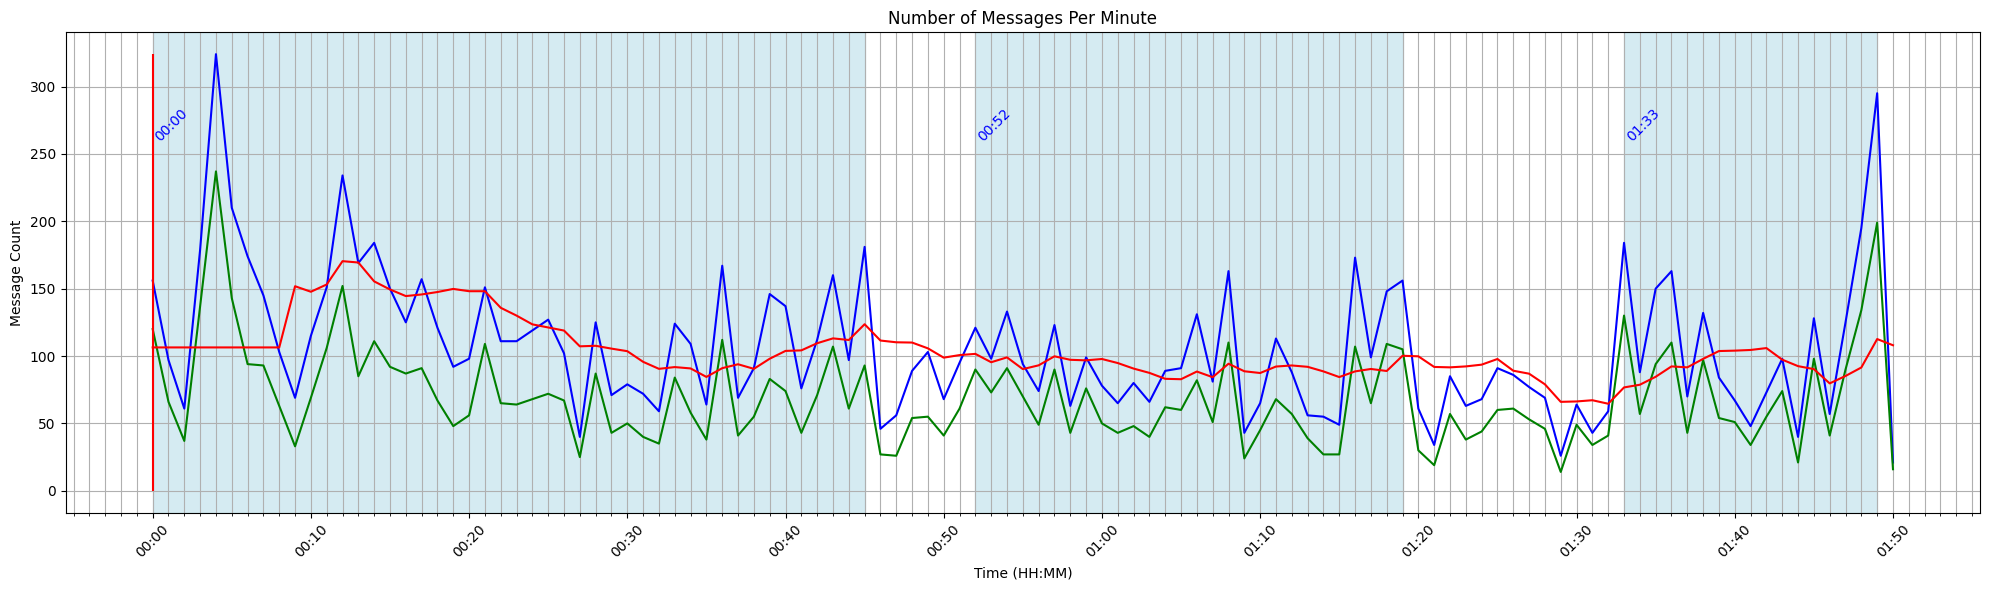

In [195]:
plt.figure(figsize=(20, 6))

plt.plot(total_messages_per_minute['time_in_minutes'], total_messages_per_minute['message_count'], label='Total Messages', color='blue')

plt.plot(member_messages_per_minute['time_in_minutes'], member_messages_per_minute['message_count'], label='Member Messages', color='green')

plt.plot(moving_average['time_in_minutes'], moving_average['message_count'], label="Moving Average", color='red')

for start, end in merged_intervals:
    plt.axvspan(start, end, color='lightblue', alpha=0.5)
    plt.text(start, total_messages_per_minute['message_count'].max() * 0.8, minutes_to_hhmm(start), color='blue', fontsize=10, rotation=45)

plt.vlines(0, ymin=0, ymax=total_messages_per_minute['message_count'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Number of Messages Per Minute')

plt.grid(True, which='both')
plt.tight_layout()
plt.savefig(os.path.join(video_path, 'timeline.png'))
plt.show()

In [196]:
with open('filter.txt', 'r', encoding='utf8') as f:
    filter_words = [word.strip() for word in f.readlines()]
pattern = re.compile(r'\b(' + '|'.join(filter_words) +
                    r')\b|(:[^:]+:)|(\(.*?\)[^\w\s]*)|(^\@\w+\s$)|(^\?+$)|\p{S}|\p{P}|\p{C}', re.IGNORECASE)
df['cleaned_message'] = df['message'].apply(
    lambda x:  recursive_replace(pattern, '', x)).replace('', np.nan)

df = df.dropna(subset='cleaned_message')
df['cleaned_message'].nunique()

3976

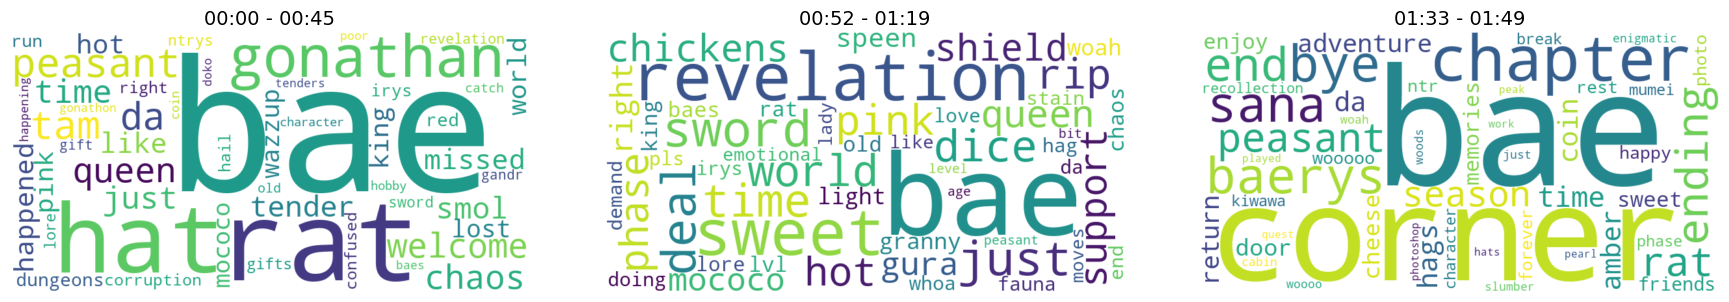

In [198]:
num_intervals = len(merged_intervals)
cols = 3
rows = math.ceil(num_intervals / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 3 * rows))

index = -1
for i, time_range in enumerate(merged_intervals):
    index += 1
    start = time_range[0] * 60
    end = time_range[1] * 60
    start_label = minutes_to_hhmm(time_range[0])
    end_label = minutes_to_hhmm(time_range[1])

    df_filtered = df[(df['time_in_seconds'] >= start) & (df['time_in_seconds'] <= end) & (df['cleaned_message'].str.len() > 0)]

    word_freq = get_word_freq(df_filtered['cleaned_message'])
    word_path = os.path.join(video_path, f'{start_label}_{end_label}'.replace(':', '-'))
    df_filtered['message'].to_csv(f'{word_path}_chat.csv', encoding='utf8', header=False)
    word_freq.to_csv(f'{word_path}_wfreq.csv', encoding='utf8', header=False)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, min_word_length=3)\
        .generate_from_frequencies(word_freq)
    ax = axes[index // cols][index % cols] if rows > 1 else axes[index % cols]

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

    ax.set_title(f'{start_label} - {end_label}', fontsize=14)

for j in range(index + 1, rows * cols):
    fig.delaxes(axes[j // cols][j % cols] if rows > 1 else axes[j % cols])

plt.tight_layout()
plt.savefig(os.path.join(video_path, 'timeline_word_cloud.png'))
plt.show()